In [1]:
import torch
import torch.nn as nn
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

<div style="background-color: lightblue; padding: 10px;">
    <p> Traditional time series models like ARIMA rely on the assumption that future values are dependent on past values.</p>
    <p style="margin: 0;"><b>Transformers,</b> initially designed for natural language processing, have recently been adapted for time series forecasting as they work well for time series patterns, exceling at capturing long-range dependencies and complex patterns.</p
</div>

<div style="background-color: lightblue; padding: 10px;">
    <p><b> How do the transformers work? see class TimeSeriesTransformer(nn.Module):</b></p>
    <p style="margin: 0;">__init__ Method: This sets up our magic box with all the parts it needs.</p>
    <p style="margin: 0;">forward Method: This is how the toy goes through the magic box, gets transformed, and comes out the other side.</p>
    <p style="margin: 0;">Input Embedding: changes the data into a shape that the magic box can understand.</p>
    <p style="margin: 0;">Positional Encoding: imagine we put a sticker on each datapoint to remember where it came from. This helps the magic box know the order of the data.</p>
        <p style="margin: 0;">Transformer: the magic box has many little wizards (layers) that work together to transform the data. They look at the data from different angles (heads) and make it better.</p>
        <p style="margin: 0;">Fully Connected Output: after the data go through the magic box, they come out of the output door. This part makes sure the data are in the right shape before they leave the box.</p>
</div>

<div style="background-color: lightblue; padding: 10px;">
    <b>Training the model. see # Initialize and train the model</b>
Imagine We're Training a Smart Robot. Setting it up:  
Model: This is our smart robot. We tell it how to look at the data and learn from it.  
Criterion: This is like a teacher who tells the robot how well it's doing. If the robot makes a mistake, the teacher gives it a score.  
Optimizer: This is like a coach who helps the robot get better. The coach tells the robot how to adjust itself to improve.  
  
Training the Robot.   
Epochs are like rounds of practice. Each round, the robot gets better at its task.  

Training Loop:  
Train Mode: The robot goes into training mode, ready to learn.  
Zero Gradients: The robot clears its mind of any previous mistakes.  
Forward Pass: The robot looks at the training data and makes a prediction.  
Calculate Loss: The teacher (criterion) tells the robot how far off its prediction was from the correct answer.  
Backward Pass: The robot learns from its mistakes. It figures out how to adjust itself to do better next time.  
Optimizer Step: The coach (optimizer) helps the robot make those adjustments.  

Evaluation Loop:  
Eval Mode: The robot goes into evaluation mode, where it doesn't learn but just checks how well it's doing.  
No Gradient Calculation: The robot doesn't need to learn here, so it doesn't calculate gradients.  
Test Prediction: The robot looks at the test data and makes a prediction.  
Calculate Test Loss: The teacher (criterion) tells the robot how well it did on the test data.  
  
Print Progress:  
After each round (epoch), we print out how well the robot did during training and testing. </div>

C:\Users\thesk\anaconda3\lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1, Train Loss: 0.1374, Test Loss: 5.2973
Epoch 2, Train Loss: 4.7981, Test Loss: 0.7983
Epoch 3, Train Loss: 0.6876, Test Loss: 0.2749
Epoch 4, Train Loss: 0.3288, Test Loss: 0.6104
Epoch 5, Train Loss: 0.6673, Test Loss: 0.3990
Epoch 6, Train Loss: 0.4492, Test Loss: 0.1595
Epoch 7, Train Loss: 0.1991, Test Loss: 0.0799
Epoch 8, Train Loss: 0.0887, Test Loss: 0.1440
Epoch 9, Train Loss: 0.1256, Test Loss: 0.2221
Epoch 10, Train Loss: 0.1822, Test Loss: 0.2347
Epoch 11, Train Loss: 0.1938, Test Loss: 0.1965
Epoch 12, Train Loss: 0.1616, Test Loss: 0.1431
Epoch 13, Train Loss: 0.1245, Test Loss: 0.1017
Epoch 14, Train Loss: 0.0978, Test Loss: 0.0821
Epoch 15, Train Loss: 0.0907, Test Loss: 0.0811
Epoch 16, Train Loss: 0.0992, Test Loss: 0.0884
Epoch 17, Train Loss: 0.1132, Test Loss: 0.0947
Epoch 18, Train Loss: 0.1206, Test Loss: 0.0953
Epoch 19, Train Loss: 0.1183, Test Loss: 0.0908
Epoch 20, Train Loss: 0.1145, Test Loss: 0.0845


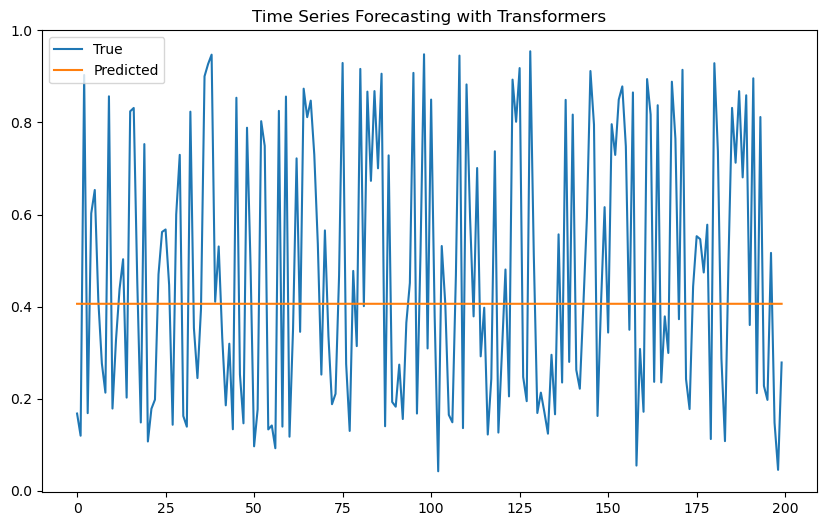

In [2]:
# Generate fake time series data or a bunch of wavy lines
def generate_time_series(seq_length=50, n_samples=1000):   # This means each wavy line will have 50 points and we will make 1000 wavy lines
    x = np.linspace(0, 4 * np.pi, seq_length)              # This sets up the points for our wave. Imagine drawing 50 dots along the wave
    y = np.sin(x) + 0.1 * np.random.normal(size=x.shape)   # This creates the base wave (made of x, y points) with some noise.
    data = [] 
    for _ in range(n_samples):        # We use a loop to make 1000 wavy lines. Each time, we shift the wave a little bit and add some noise to make it look different.
        noise = 0.1 * np.random.normal(size=x.shape)       # Shift the sine wave slightly for each sample
        sample = np.sin(x + np.random.uniform(0, 2 * np.pi)) + noise
        data.append(sample)
    return np.array(data)

# Data preparation
seq_length = 50
data = generate_time_series(seq_length=seq_length, n_samples=1000)  # A collection of 1000 wavy lines, each with 50 points and a litle bit different
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

X = data[:, :-1]
y = data[:, -1]

# Convert to PyTorch tensors
train_size = int(len(X) * 0.8)
X_train, y_train = torch.tensor(X[:train_size], dtype=torch.float32), torch.tensor(y[:train_size], dtype=torch.float32)
X_test, y_test = torch.tensor(X[train_size:], dtype=torch.float32), torch.tensor(y[train_size:], dtype=torch.float32)

# Transformer model for time series forecasting
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, model_dim, n_heads, n_layers, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.input_embedding = nn.Linear(input_dim, model_dim)
        self.model_dim = model_dim
        self.positional_encoding = nn.Parameter(torch.zeros(1, seq_length, model_dim))
        self.transformer = nn.Transformer(d_model=model_dim, nhead=n_heads, num_encoder_layers=n_layers, dropout=dropout)
        self.fc_out = nn.Linear(model_dim, 1)
    
    def forward(self, x):
        # Adjust positional encoding dynamically based on input sequence length
        seq_len = x.size(1)
        pos_encoding = self.positional_encoding[:, :seq_len, :]
        x = self.input_embedding(x) + pos_encoding
        
        # Transformer expects (sequence_length, batch_size, model_dim)
        x = x.permute(1, 0, 2)
        x = self.transformer(x, x)
        
        # Back to (batch_size, sequence_length, model_dim)
        x = x.permute(1, 0, 2)
        x = self.fc_out(x[:, -1, :])  # Predict only the last timestep
        return x


# Initialize and train the model
model = TimeSeriesTransformer(input_dim=1, model_dim=64, n_heads=4, n_layers=2)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 20
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()  # Start fresh. Telling the robot to forget about the old mistakes and focus on learning from the new ones.
    output = model(X_train.unsqueeze(-1))  # Add a feature or like a box for each datapoint that distinguishes them instead of seeing them all jumbled together (-1, add at the end) so the model can see them better
    loss = criterion(output.squeeze(), y_train) # Squeezes to flatten the robot's predictions to remove any extra dimensions and calculates the loss (score) by comparing the robot's predictions with the correct answers (y-train). The teacher (criterion) tells the robot how well it's doing.
    loss.backward()  # If the robot made a mistake, this step is the robot thinking about what it did wrong. It figures out how to adjust itself to do better next time.
    optimizer.step() # The robot actually makes the adjustments. The coach (optimizer) helps the robot change itself based on what it learned from the mistake.

    model.eval()
    with torch.no_grad():  # Evaluate only, telling the robot to take a break from learning. It won't calculate gradients or try to learn from its mistakes.
        test_output = model(X_test.unsqueeze(-1))
        test_loss = criterion(test_output.squeeze(), y_test)

    print(f"Epoch {epoch + 1}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

# Plot predictions
model.eval()
with torch.no_grad():
    preds = model(X_test.unsqueeze(-1)).squeeze().numpy()

plt.figure(figsize=(10, 6))
plt.plot(y_test.numpy(), label="True")
plt.plot(preds, label="Predicted")
plt.legend()
plt.title("Time Series Forecasting with Transformers")
plt.show()

## Real life data

In [10]:
# Load the supermarket sales dataset to inspect its structure
file_path = 'supermarket_sales.csv'
supermarket_data = pd.read_csv(file_path)

# Display the first few rows of the dataset
supermarket_data.head(), supermarket_data.info()

# Convert the 'Date' column to datetime format and aggregate sales by day
supermarket_data['Date'] = pd.to_datetime(supermarket_data['Date'])
daily_sales = supermarket_data.groupby('Date')['Total'].sum().reset_index()

# Sort the data by date for consistency
daily_sales = daily_sales.sort_values(by='Date').reset_index(drop=True)

# Display the first few rows of the processed time-series data
daily_sales.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Invoice ID               1000 non-null   object 
 1   Branch                   1000 non-null   object 
 2   City                     1000 non-null   object 
 3   Customer type            1000 non-null   object 
 4   Gender                   1000 non-null   object 
 5   Product line             1000 non-null   object 
 6   Unit price               1000 non-null   float64
 7   Quantity                 1000 non-null   int64  
 8   Tax 5%                   1000 non-null   float64
 9   Total                    1000 non-null   float64
 10  Date                     1000 non-null   object 
 11  Time                     1000 non-null   object 
 12  Payment                  1000 non-null   object 
 13  cogs                     1000 non-null   float64
 14  gross margin percentage  

,Date,Total
0,2019-01-01,4745.1810
1,2019-01-02,1945.5030
2,2019-01-03,2078.1285
3,2019-01-04,1623.6885
4,2019-01-05,3536.6835


### 10 epochs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Invoice ID               1000 non-null   object 
 1   Branch                   1000 non-null   object 
 2   City                     1000 non-null   object 
 3   Customer type            1000 non-null   object 
 4   Gender                   1000 non-null   object 
 5   Product line             1000 non-null   object 
 6   Unit price               1000 non-null   float64
 7   Quantity                 1000 non-null   int64  
 8   Tax 5%                   1000 non-null   float64
 9   Total                    1000 non-null   float64
 10  Date                     1000 non-null   object 
 11  Time                     1000 non-null   object 
 12  Payment                  1000 non-null   object 
 13  cogs                     1000 non-null   float64
 14  gross margin percentage  

C:\Users\thesk\anaconda3\lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\thesk\anaconda3\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([31, 1])) that is different to the input size (torch.Size([31])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10, Loss: 0.10171861201524734
Epoch 2/10, Loss: 7.260791301727295
Epoch 3/10, Loss: 1.177998661994934
Epoch 4/10, Loss: 0.1875714361667633
Epoch 5/10, Loss: 0.6118249297142029
Epoch 6/10, Loss: 0.4349763095378876
Epoch 7/10, Loss: 0.190816730260849
Epoch 8/10, Loss: 0.08038369566202164
Epoch 9/10, Loss: 0.11761417239904404
Epoch 10/10, Loss: 0.18173150718212128


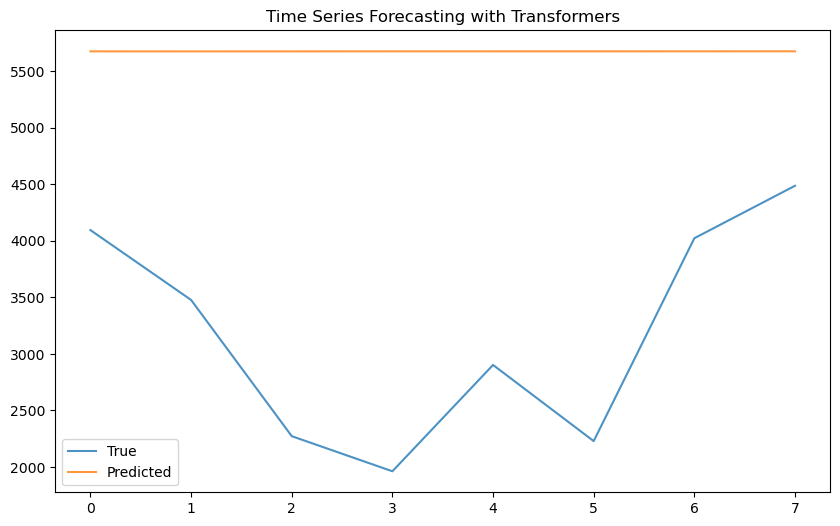

In [6]:
# Load the supermarket sales dataset to inspect its structure
file_path = 'supermarket_sales.csv'
supermarket_data = pd.read_csv(file_path)
supermarket_data.head(), supermarket_data.info()

# Convert the 'Date' column to datetime format and aggregate sales by day
supermarket_data['Date'] = pd.to_datetime(supermarket_data['Date'])
daily_sales = supermarket_data.groupby('Date')['Total'].sum().reset_index()

# Sort the data by date for consistency
daily_sales = daily_sales.sort_values(by='Date').reset_index(drop=True)
daily_sales.head()

# Prepare the time-series data for the Transformer
sequence_length = 50

# Scale the data
scaler = MinMaxScaler()
scaled_sales = scaler.fit_transform(daily_sales['Total'].values.reshape(-1, 1))

# Create sequences and targets
sequences, targets = [], []
for i in range(len(scaled_sales) - sequence_length):
    sequences.append(scaled_sales[i:i + sequence_length])
    targets.append(scaled_sales[i + sequence_length])

sequences = np.array(sequences)
targets = np.array(targets)

# Split into training and testing sets (80% train, 20% test)
train_size = int(0.8 * len(sequences))
X_train, y_train = sequences[:train_size], targets[:train_size]
X_test, y_test = sequences[train_size:], targets[train_size:]

# Convert to PyTorch tensors
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

# Create data loaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32)

# Verify the shapes
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# Define the Transformer Model
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.input_embedding = nn.Linear(input_dim, model_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(1, sequence_length, model_dim))
        self.transformer = nn.Transformer(
            d_model=model_dim, nhead=num_heads, num_encoder_layers=num_layers, dropout=dropout
        )
        self.fc_out = nn.Linear(model_dim, 1)

    def forward(self, x):
        x = self.input_embedding(x.squeeze(-1))  # Ensure the input has shape (batch_size, sequence_length, model_dim)
        x = x + self.positional_encoding
        x = x.permute(1, 0, 2)  # Switch to (sequence_length, batch_size, model_dim)
        x = self.transformer(x, x)  # Transformer expects src and tgt, using the same for simplicity
        x = x.permute(1, 0, 2)  # Switch back to (batch_size, sequence_length, model_dim)
        x = self.fc_out(x[:, -1, :])  # Use the output of the last sequence step
        return x

# Initialize model, loss, and optimizer
model = TimeSeriesTransformer(input_dim=1, model_dim=64, num_heads=4, num_layers=2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch.unsqueeze(-1))  # Add feature dimension
        loss = criterion(output.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader)}")

# Evaluate and plot
model.eval()
predictions, true_values = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        output = model(X_batch.unsqueeze(-1))
        predictions.extend(output.squeeze().tolist())
        true_values.extend(y_batch.tolist())

# Rescale predictions and true values to original scale
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
true_values = scaler.inverse_transform(np.array(true_values).reshape(-1, 1))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(true_values, label="True", alpha=0.8)
plt.plot(predictions, label="Predicted", alpha=0.8)
plt.title("Time Series Forecasting with Transformers")
plt.legend()
plt.show()

### 50 epochs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Invoice ID               1000 non-null   object 
 1   Branch                   1000 non-null   object 
 2   City                     1000 non-null   object 
 3   Customer type            1000 non-null   object 
 4   Gender                   1000 non-null   object 
 5   Product line             1000 non-null   object 
 6   Unit price               1000 non-null   float64
 7   Quantity                 1000 non-null   int64  
 8   Tax 5%                   1000 non-null   float64
 9   Total                    1000 non-null   float64
 10  Date                     1000 non-null   object 
 11  Time                     1000 non-null   object 
 12  Payment                  1000 non-null   object 
 13  cogs                     1000 non-null   float64
 14  gross margin percentage  

C:\Users\thesk\anaconda3\lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\thesk\anaconda3\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([31, 1])) that is different to the input size (torch.Size([31])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/50, Loss: 0.4354504644870758
Epoch 2/50, Loss: 8.003783226013184
Epoch 3/50, Loss: 1.2868690490722656
Epoch 4/50, Loss: 0.2025356888771057
Epoch 5/50, Loss: 0.7075115442276001
Epoch 6/50, Loss: 0.4719478487968445
Epoch 7/50, Loss: 0.17422634363174438
Epoch 8/50, Loss: 0.0815255418419838
Epoch 9/50, Loss: 0.12688380479812622
Epoch 10/50, Loss: 0.2193678617477417
Epoch 11/50, Loss: 0.2188984602689743
Epoch 12/50, Loss: 0.15632259845733643
Epoch 13/50, Loss: 0.12006177753210068
Epoch 14/50, Loss: 0.0812406837940216
Epoch 15/50, Loss: 0.0771125853061676
Epoch 16/50, Loss: 0.1044146716594696
Epoch 17/50, Loss: 0.1220683678984642
Epoch 18/50, Loss: 0.13628429174423218
Epoch 19/50, Loss: 0.10992175340652466
Epoch 20/50, Loss: 0.10208961367607117
Epoch 21/50, Loss: 0.0895366296172142
Epoch 22/50, Loss: 0.08261831104755402
Epoch 23/50, Loss: 0.07649055868387222
Epoch 24/50, Loss: 0.07688829302787781
Epoch 25/50, Loss: 0.08509210497140884
Epoch 26/50, Loss: 0.08511574566364288
Epoch 27/5

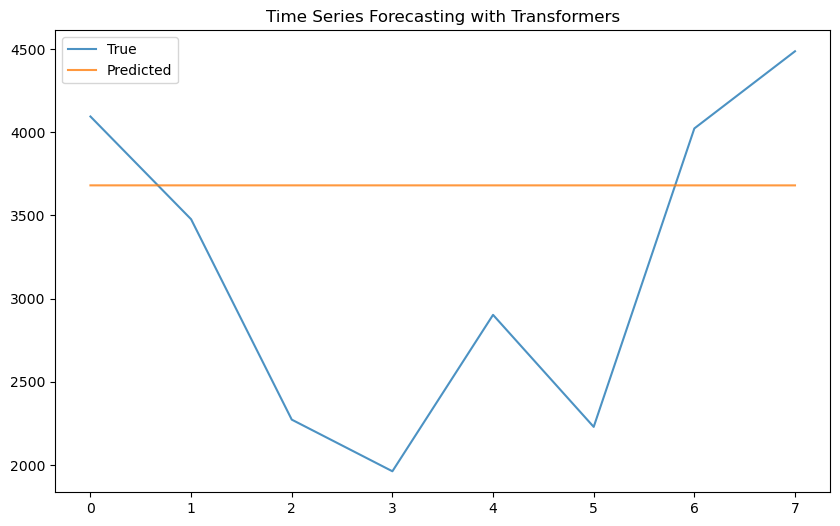

In [5]:
# Load the supermarket sales dataset to inspect its structure
file_path = 'supermarket_sales.csv'
supermarket_data = pd.read_csv(file_path)
supermarket_data.head(), supermarket_data.info()

# Convert the 'Date' column to datetime format and aggregate sales by day
supermarket_data['Date'] = pd.to_datetime(supermarket_data['Date'])
daily_sales = supermarket_data.groupby('Date')['Total'].sum().reset_index()

# Sort the data by date for consistency
daily_sales = daily_sales.sort_values(by='Date').reset_index(drop=True)
daily_sales.head()

# Prepare the time-series data for the Transformer
sequence_length = 50

# Scale the data
scaler = MinMaxScaler()
scaled_sales = scaler.fit_transform(daily_sales['Total'].values.reshape(-1, 1))

# Create sequences and targets
sequences, targets = [], []
for i in range(len(scaled_sales) - sequence_length):
    sequences.append(scaled_sales[i:i + sequence_length])
    targets.append(scaled_sales[i + sequence_length])

sequences = np.array(sequences)
targets = np.array(targets)

# Split into training and testing sets (80% train, 20% test)
train_size = int(0.8 * len(sequences))
X_train, y_train = sequences[:train_size], targets[:train_size]
X_test, y_test = sequences[train_size:], targets[train_size:]

# Convert to PyTorch tensors
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

# Create data loaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32)

# Verify the shapes
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# Define the Transformer Model
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.input_embedding = nn.Linear(input_dim, model_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(1, sequence_length, model_dim))
        self.transformer = nn.Transformer(
            d_model=model_dim, nhead=num_heads, num_encoder_layers=num_layers, dropout=dropout
        )
        self.fc_out = nn.Linear(model_dim, 1)

    def forward(self, x):
        x = self.input_embedding(x.squeeze(-1))  # Ensure the input has shape (batch_size, sequence_length, model_dim)
        x = x + self.positional_encoding
        x = x.permute(1, 0, 2)  # Switch to (sequence_length, batch_size, model_dim)
        x = self.transformer(x, x)  # Transformer expects src and tgt, using the same for simplicity
        x = x.permute(1, 0, 2)  # Switch back to (batch_size, sequence_length, model_dim)
        x = self.fc_out(x[:, -1, :])  # Use the output of the last sequence step
        return x

# Initialize model, loss, and optimizer
model = TimeSeriesTransformer(input_dim=1, model_dim=64, num_heads=4, num_layers=2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch.unsqueeze(-1))  # Add feature dimension
        loss = criterion(output.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader)}")

# Evaluate and plot
model.eval()
predictions, true_values = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        output = model(X_batch.unsqueeze(-1))
        predictions.extend(output.squeeze().tolist())
        true_values.extend(y_batch.tolist())

# Rescale predictions and true values to original scale
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
true_values = scaler.inverse_transform(np.array(true_values).reshape(-1, 1))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(true_values, label="True", alpha=0.8)
plt.plot(predictions, label="Predicted", alpha=0.8)
plt.title("Time Series Forecasting with Transformers")
plt.legend()
plt.show()

In [4]:
print(X_batch.shape)

torch.Size([8, 50, 1])


### 100 epochs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Invoice ID               1000 non-null   object 
 1   Branch                   1000 non-null   object 
 2   City                     1000 non-null   object 
 3   Customer type            1000 non-null   object 
 4   Gender                   1000 non-null   object 
 5   Product line             1000 non-null   object 
 6   Unit price               1000 non-null   float64
 7   Quantity                 1000 non-null   int64  
 8   Tax 5%                   1000 non-null   float64
 9   Total                    1000 non-null   float64
 10  Date                     1000 non-null   object 
 11  Time                     1000 non-null   object 
 12  Payment                  1000 non-null   object 
 13  cogs                     1000 non-null   float64
 14  gross margin percentage  

C:\Users\thesk\anaconda3\lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\thesk\anaconda3\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([31, 1])) that is different to the input size (torch.Size([31])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/100, Loss: 1.0127911567687988
Epoch 2/100, Loss: 6.748830318450928
Epoch 3/100, Loss: 2.0468225479125977
Epoch 4/100, Loss: 0.13288745284080505
Epoch 5/100, Loss: 0.34944358468055725
Epoch 6/100, Loss: 0.7091167569160461
Epoch 7/100, Loss: 0.5169772505760193
Epoch 8/100, Loss: 0.23349213600158691
Epoch 9/100, Loss: 0.08730469644069672
Epoch 10/100, Loss: 0.10717874020338058
Epoch 11/100, Loss: 0.20853640139102936
Epoch 12/100, Loss: 0.24381765723228455
Epoch 13/100, Loss: 0.2193818837404251
Epoch 14/100, Loss: 0.15545552968978882
Epoch 15/100, Loss: 0.1193750724196434
Epoch 16/100, Loss: 0.08029663562774658
Epoch 17/100, Loss: 0.08232636749744415
Epoch 18/100, Loss: 0.08972978591918945
Epoch 19/100, Loss: 0.11034460365772247
Epoch 20/100, Loss: 0.12024503946304321
Epoch 21/100, Loss: 0.11286495625972748
Epoch 22/100, Loss: 0.10967258363962173
Epoch 23/100, Loss: 0.09742312133312225
Epoch 24/100, Loss: 0.08520285785198212
Epoch 25/100, Loss: 0.08964531123638153
Epoch 26/100, Los

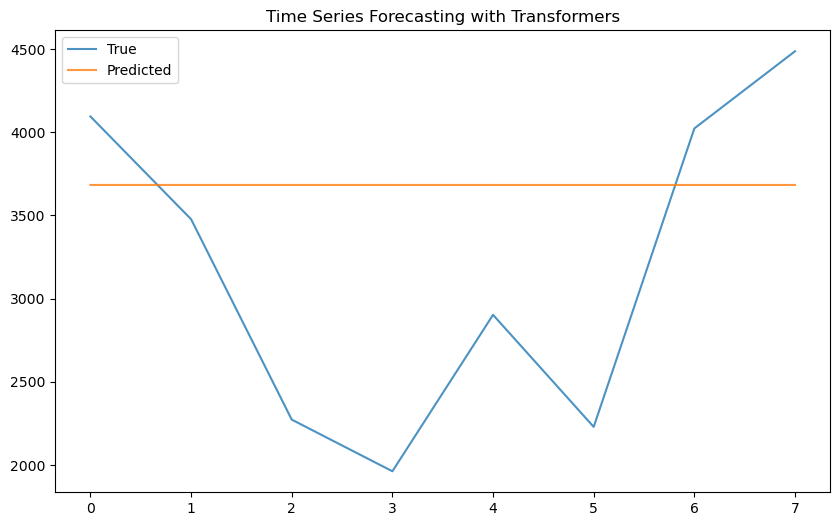

In [7]:
# Load the supermarket sales dataset to inspect its structure
file_path = 'supermarket_sales.csv'
supermarket_data = pd.read_csv(file_path)
supermarket_data.head(), supermarket_data.info()

# Convert the 'Date' column to datetime format and aggregate sales by day
supermarket_data['Date'] = pd.to_datetime(supermarket_data['Date'])
daily_sales = supermarket_data.groupby('Date')['Total'].sum().reset_index()

# Sort the data by date for consistency
daily_sales = daily_sales.sort_values(by='Date').reset_index(drop=True)
daily_sales.head()

# Prepare the time-series data for the Transformer
sequence_length = 50

# Scale the data
scaler = MinMaxScaler()
scaled_sales = scaler.fit_transform(daily_sales['Total'].values.reshape(-1, 1))

# Create sequences and targets
sequences, targets = [], []
for i in range(len(scaled_sales) - sequence_length):
    sequences.append(scaled_sales[i:i + sequence_length])
    targets.append(scaled_sales[i + sequence_length])

sequences = np.array(sequences)
targets = np.array(targets)

# Split into training and testing sets (80% train, 20% test)
train_size = int(0.8 * len(sequences))
X_train, y_train = sequences[:train_size], targets[:train_size]
X_test, y_test = sequences[train_size:], targets[train_size:]

# Convert to PyTorch tensors
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

# Creates data loaders to efficiently load the training and testing data in batches
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32)

# Verify the shapes
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# Define the Transformer Model
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.input_embedding = nn.Linear(input_dim, model_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(1, sequence_length, model_dim))
        self.transformer = nn.Transformer(
            d_model=model_dim, nhead=num_heads, num_encoder_layers=num_layers, dropout=dropout
        )
        self.fc_out = nn.Linear(model_dim, 1)

    def forward(self, x):
        x = self.input_embedding(x.squeeze(-1))  # Ensure the input has shape (batch_size, sequence_length, model_dim)
        x = x + self.positional_encoding
        x = x.permute(1, 0, 2)  # Switch to (sequence_length, batch_size, model_dim)
        x = self.transformer(x, x)  # Transformer expects src and tgt, using the same for simplicity
        x = x.permute(1, 0, 2)  # Switch back to (batch_size, sequence_length, model_dim)
        x = self.fc_out(x[:, -1, :])  # Use the output of the last sequence step
        return x

# Initialize model, loss, and optimizer
model = TimeSeriesTransformer(input_dim=1, model_dim=64, num_heads=4, num_layers=2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 100
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch.unsqueeze(-1))  # Add feature dimension
        loss = criterion(output.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader)}")

# Evaluate and plot
model.eval()
predictions, true_values = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        output = model(X_batch.unsqueeze(-1))
        predictions.extend(output.squeeze().tolist())
        true_values.extend(y_batch.tolist())

# Rescale predictions and true values to original scale
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
true_values = scaler.inverse_transform(np.array(true_values).reshape(-1, 1))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(true_values, label="True", alpha=0.8)
plt.plot(predictions, label="Predicted", alpha=0.8)
plt.title("Time Series Forecasting with Transformers")
plt.legend()
plt.show()

10 epochs were not enough to train the model.  
No difference between 50 and 100 epochs.